In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# TA-Lib for indicators
import talib

# PyNance and PyFolio will be used later, we just import them now
import talib                      # technical indicators
import pynance as py              # from GitHub version
import quantstats as qs   

# Make plots a bit nicer
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)


## Load or download a data (AMZN)

In [3]:
# ============================================
# Download AMZN daily data for a year
# ============================================

ticker = "AMZN"
start_date = "2009-01-01"
end_date   = "2023-12-29"

df = yf.download(ticker, start=start_date, end=end_date, progress=False) 
df.head()


C:\Users\Birhanu Matebe\AppData\Local\Temp\ipykernel_19980\829291597.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2009-01-02,2.718,2.7265,2.5535,2.5675,145928000
2009-01-05,2.703,2.7870,2.6515,2.7865,190196000
2009-01-06,2.868,2.9110,2.6875,2.7275,221602000
2009-01-07,2.810,2.8475,2.7675,2.8145,158854000
2009-01-08,2.858,2.8660,2.7290,2.7495,131558000


# 1. Data profiling

In [4]:
# ============================================
# Clean the columns (handle MultiIndex case)
# ============================================

# If columns are MultiIndex (like: ('Close', 'AMZN')), flatten them
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)  # keep only first level: Open, High, etc.

print("Cleaned columns:", df.columns.tolist())

# Optional: add a Ticker column (useful if using multiple tickers later)
df["Ticker"] = ticker

# Ensure index is datetime and sorted
df.index = pd.to_datetime(df.index)
df = df.sort_index()




Cleaned columns: ['Close', 'High', 'Low', 'Open', 'Volume']


# - Summary Statistics 

In [5]:
# log the shape of dataset and the first five rows of dataset
print(f'the shape of AMZN dataset ${df.shape}')
df.head()

the shape of AMZN dataset $(3773, 6)


Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2009-01-02,2.718,2.7265,2.5535,2.5675,145928000,AMZN
2009-01-05,2.703,2.7870,2.6515,2.7865,190196000,AMZN
2009-01-06,2.868,2.9110,2.6875,2.7275,221602000,AMZN
2009-01-07,2.810,2.8475,2.7675,2.8145,158854000,AMZN
2009-01-08,2.858,2.8660,2.7290,2.7495,131558000,AMZN


In [6]:
# log the last examples of this dataset
df.tail()

Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2023-12-21,153.839996,153.970001,152.100006,153.300003,36305700,AMZN
2023-12-22,153.419998,154.350006,152.710007,153.770004,29514100,AMZN
2023-12-26,153.410004,153.979996,153.029999,153.559998,25067200,AMZN
2023-12-27,153.339996,154.779999,153.119995,153.559998,31434700,AMZN
2023-12-28,153.380005,154.080002,152.949997,153.720001,27057000,AMZN


In [7]:
# log the last examples of this dataset
df.sample(5)

Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2013-01-02,12.865500,12.905000,12.663000,12.804000,65420000,AMZN
2023-04-10,102.169998,102.199997,99.570000,100.959999,37261200,AMZN
2019-02-04,81.665497,82.481499,80.675003,81.150002,98582000,AMZN
2015-03-18,18.757000,18.799500,18.334999,18.498501,53082000,AMZN
2017-04-18,45.188999,45.480499,45.039001,45.049500,59984000,AMZN


In [8]:
# check more information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3773 entries, 2009-01-02 to 2023-12-28
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3773 non-null   float64
 1   High    3773 non-null   float64
 2   Low     3773 non-null   float64
 3   Open    3773 non-null   float64
 4   Volume  3773 non-null   int64  
 5   Ticker  3773 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 206.3+ KB


In [9]:
# check if a null value exists
print("Check for missing values:")
df.isna().sum()

Check for missing values:


Price
Close     0
High      0
Low       0
Open      0
Volume    0
Ticker    0
dtype: int64

In [10]:
# 1. Calculate the percentage of missing values for every column
null_percentages = df.isnull().sum() / len(df) * 100

# 2. Filter the resulting Series for percentages greater than 5
columns_with_high_nulls = null_percentages[null_percentages > 5]

# 3. Print the results
print("Columns with >5% Null Values:")
print(columns_with_high_nulls)

Columns with >5% Null Values:
Series([], dtype: float64)


In [11]:
# Check if null rows exist
# 1. Define the critical columns
key_cols = ['Close', 'Open', 'High', 'Volume', 'Ticker']

# 2. Create a boolean mask:
missing_rows_mask = df[key_cols].isnull().any(axis=1)

# 3. Use the mask to display the subset of rows with missing data
missing_value_rows = df[missing_rows_mask]

# 4. Display the resulting DataFrame
print(f"Total rows with missing values in the key columns: {len(missing_value_rows)}")
print("Rows with Missing Data (only showing the key columns for focus):")
print(missing_value_rows[key_cols])

Total rows with missing values in the key columns: 0
Rows with Missing Data (only showing the key columns for focus):
Empty DataFrame
Columns: [Close, Open, High, Volume, Ticker]
Index: []


In [12]:
# log statistical data values
print("The description of the numeric columns:")
print(df.describe())

The description of the numeric columns:
Price        Close         High          Low         Open        Volume
count  3773.000000  3773.000000  3773.000000  3773.000000  3.773000e+03
mean     59.383569    60.091536    58.645009    59.399097  9.186562e+07
std      54.905147    55.597187    54.220310    54.939879  6.057763e+07
min       2.422000     2.505000     2.381500     2.428000  1.762600e+07
25%      12.194000    12.288500    12.033500    12.142500  5.587400e+07
50%      36.336498    36.478001    35.980499    36.320000  7.520800e+07
75%      96.629997    97.750000    95.378998    96.654503  1.086140e+08
max     186.570496   188.654007   184.839493   187.199997  1.166116e+09


In [13]:
#Overview of categorical columns
print("The description of the categorical columns:")
print(df.describe(include=['object']))

The description of the categorical columns:
Price  Ticker
count    3773
unique      1
top      AMZN
freq     3773


In [14]:
# log and check the frequency, and uniqueness of all dataset column
print("The description of all columns:")
print(df.describe(include='all'))


The description of all columns:
Price         Close         High          Low         Open        Volume  \
count   3773.000000  3773.000000  3773.000000  3773.000000  3.773000e+03   
unique          NaN          NaN          NaN          NaN           NaN   
top             NaN          NaN          NaN          NaN           NaN   
freq            NaN          NaN          NaN          NaN           NaN   
mean      59.383569    60.091536    58.645009    59.399097  9.186562e+07   
std       54.905147    55.597187    54.220310    54.939879  6.057763e+07   
min        2.422000     2.505000     2.381500     2.428000  1.762600e+07   
25%       12.194000    12.288500    12.033500    12.142500  5.587400e+07   
50%       36.336498    36.478001    35.980499    36.320000  7.520800e+07   
75%       96.629997    97.750000    95.378998    96.654503  1.086140e+08   
max      186.570496   188.654007   184.839493   187.199997  1.166116e+09   

Price  Ticker  
count    3773  
unique      1  
top    

In [15]:
#check if duplication of rows exist
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

Duplicate rows: 0


In [16]:
# Cardinality (uniqueness) for categoricals
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
cardinality = {c: df[c].nunique() for c in cat_cols}
print("Cardinality (categoricals):", cardinality)

Cardinality (categoricals): {'Ticker': 1}


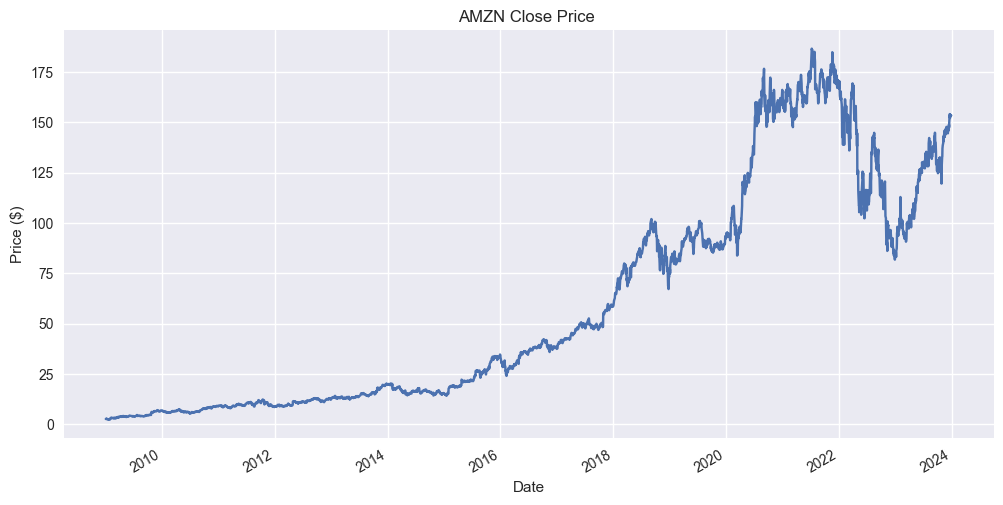

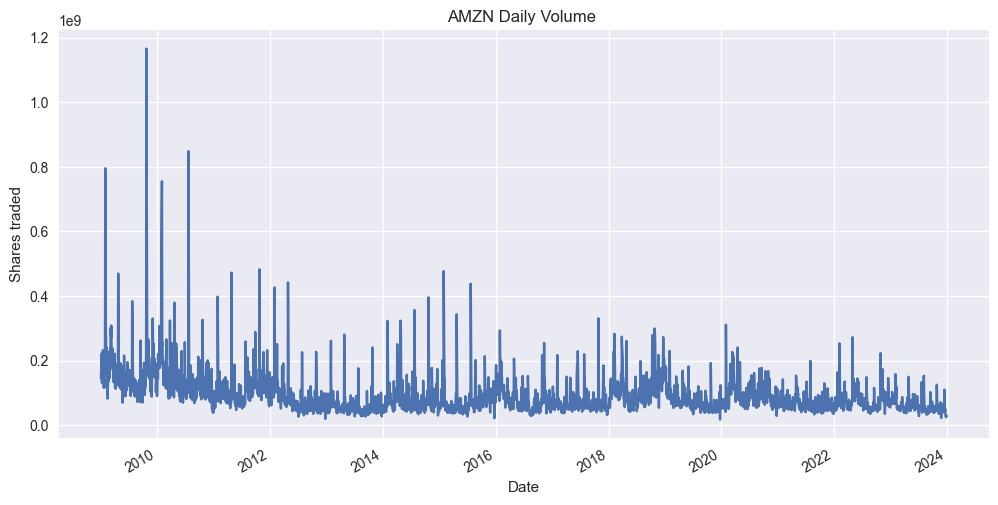

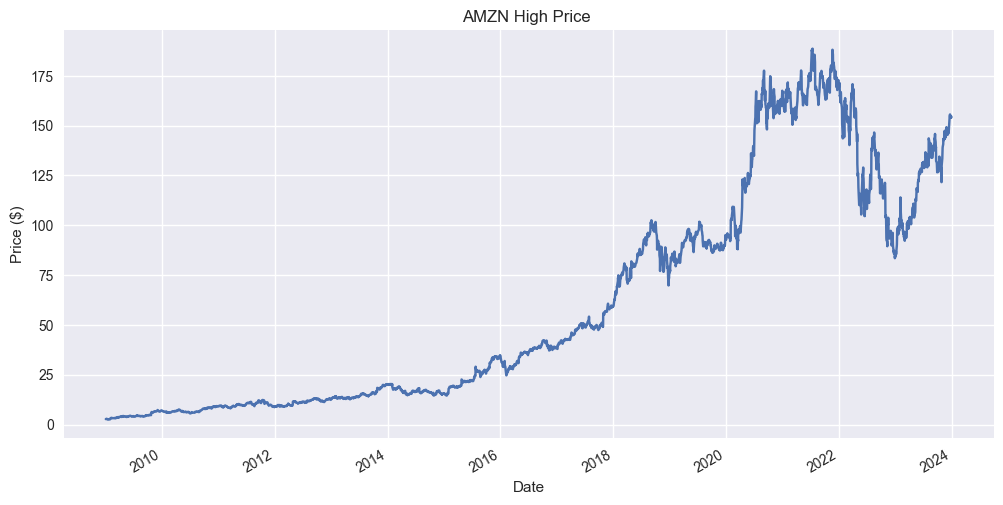

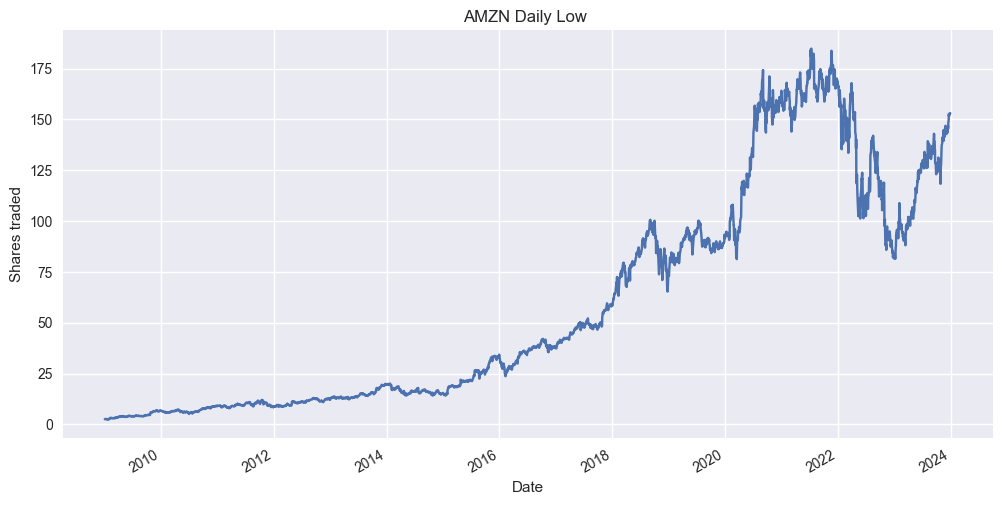

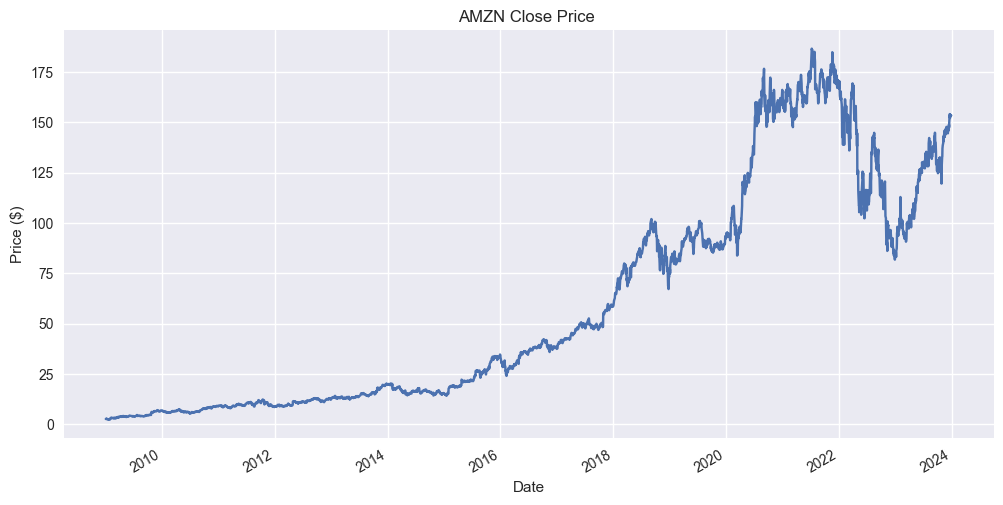

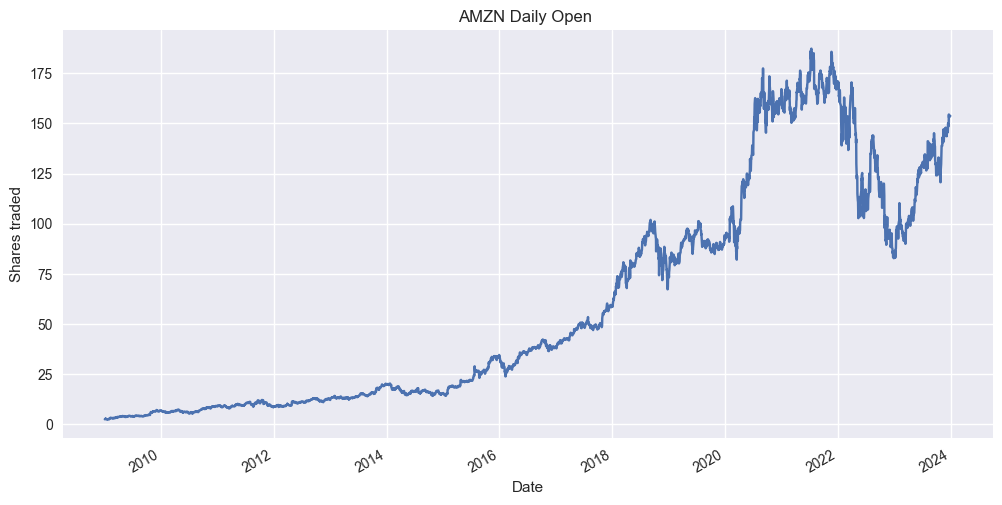

In [17]:
# ============================================
# Quick look at price and volume
# ============================================

# Close price chart
df["Close"].plot(title="AMZN Close Price ")
plt.ylabel("Price ($)")
plt.show()

# Volume chart
df["Volume"].plot(title="AMZN Daily Volume ")
plt.ylabel("Shares traded")
plt.show()
df["High"].plot(title="AMZN High Price ")
plt.ylabel("Price ($)")
plt.show()

# Volume chart
df["Low"].plot(title="AMZN Daily Low ")
plt.ylabel("Shares traded")
plt.show()
df["Close"].plot(title="AMZN Close Price ")
plt.ylabel("Price ($)")
plt.show()

# Volume chart
df["Open"].plot(title="AMZN Daily Open ")
plt.ylabel("Shares traded")
plt.show()


## Stock price over time

## Interpretation of Amazon (AMZN) Close Price History (2009–2024)

- This chart, displaying the daily closing price of Amazon stock over approximately 15 years, illustrates a period of extraordinary growth characterized by high volatility.

1. The Long-Term Trend: Massive Appreciation
- The most evident feature is the massive, sustained upward trend. The stock price rose from under $10 (split-adjusted) in the late 2000s/early 2010s to its all-time peak near $180 in 2021. This reflects Amazon's successful dominance in both e-commerce and its highly profitable cloud computing division, Amazon Web Services (AWS).

2. Key Phases of Price Movement
- 2009 – 2018: Consistent, Steady Ascent: The stock price climbed steadily, confirming the long-term viability of the business model. While there were corrections, they were relatively shallow compared to later movements.

- 2019 – Mid-2021: Explosive Peak Rally: The growth rate accelerated dramatically, driven by the strong performance of AWS and the massive, forced adoption of e-commerce during the global pandemic. The stock reached its peak valuation during this period.

- Mid-2021 – Late 2022: Major Bear Market Correction: This phase is the most defining feature of the chart's later years. The price experienced a sharp and prolonged decline, falling from its peak of roughly $180 to a low around $80. This deep correction was caused by a combination of macroeconomic factors (rising inflation, interest rates) and concerns over the profitability of the core retail business as pandemic-era spending slowed. This represents a significant and painful drawdown for investors.

- 2023 – Early 2024: Strong Recovery: The stock price began a vigorous comeback, climbing back toward the $150 range. This recovery indicates renewed investor confidence, likely stemming from successful company-wide cost-cutting measures and the continued robust profitability of AWS.

3. Summary of Volatility
- The chart shows that while AMZN has delivered massive long-term returns, it has done so with very high volatility. The price experienced a much more severe and sustained bear market correction in 2022 than many of its Big Tech peers, emphasizing the stock's greater sensitivity to macroeconomic shifts and changes in core business profitability.

In [18]:
# ============================================
# Compute technical indicators with TA-Lib
# ============================================

# Use 'Adj Close' if available, otherwise 'Close'
if "Adj Close" in df.columns:
    price = df["Adj Close"]
else:
    price = df["Close"]

# --- Moving Averages ---
df["SMA_20"] = talib.SMA(price, timeperiod=20)
df["SMA_50"] = talib.SMA(price, timeperiod=50)
df["EMA_20"] = talib.EMA(price, timeperiod=20)

# --- RSI ---
df["RSI_14"] = talib.RSI(price, timeperiod=14)

# --- MACD ---
df["MACD"], df["MACD_signal"], df["MACD_hist"] = talib.MACD(
    price, fastperiod=12, slowperiod=26, signalperiod=9
)


df.tail()


Price,Close,High,Low,Open,Volume,Ticker,SMA_20,SMA_50,EMA_20,RSI_14,MACD,MACD_signal,MACD_hist
Date,,,,,,,,,,,,,
2023-12-21,153.839996,153.970001,152.100006,153.300003,36305700,AMZN,148.245000,140.8212,148.380545,65.305020,3.111417,2.807326,0.304091
2023-12-22,153.419998,154.350006,152.710007,153.770004,29514100,AMZN,148.578999,141.2430,148.860492,64.115558,3.135958,2.873052,0.262905
2023-12-26,153.410004,153.979996,153.029999,153.559998,25067200,AMZN,148.863000,141.7154,149.293779,64.085644,3.118650,2.922172,0.196478
2023-12-27,153.339996,154.779999,153.119995,153.559998,31434700,AMZN,149.178500,142.1312,149.679133,63.860893,3.063965,2.950530,0.113434
2023-12-28,153.380005,154.080002,152.949997,153.720001,27057000,AMZN,149.531499,142.5694,150.031597,63.938728,2.989395,2.958303,0.031092


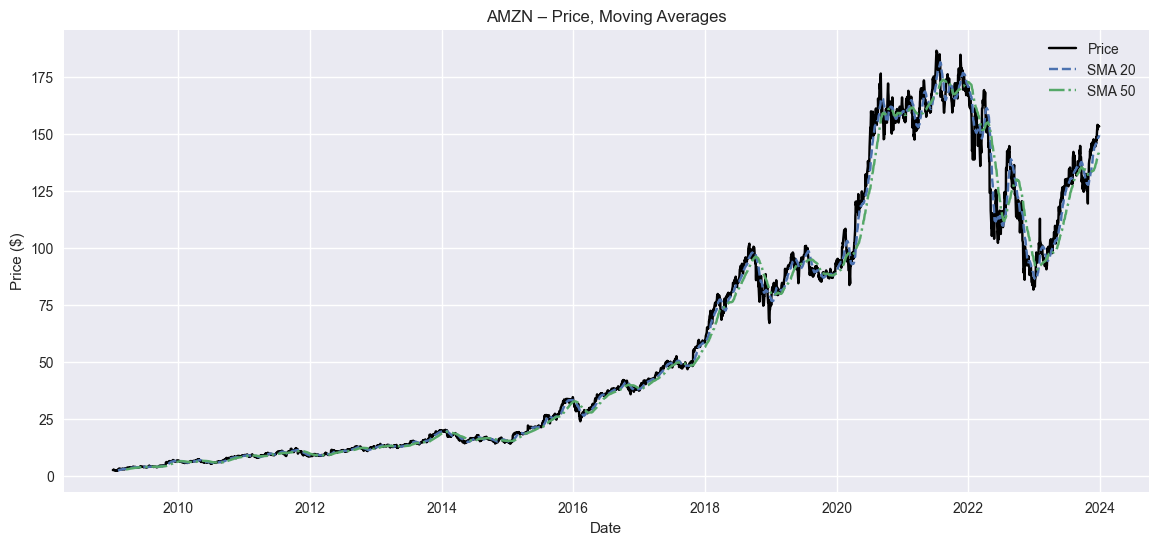

In [19]:
# ============================================
# Price + SMA + Bollinger Bands
# ============================================

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df.index, price, label="Price", color="black")
ax.plot(df.index, df["SMA_20"], label="SMA 20", linestyle="--")
ax.plot(df.index, df["SMA_50"], label="SMA 50", linestyle="-.")


ax.set_title("AMZN – Price, Moving Averages")
ax.set_xlabel("Date")
ax.set_ylabel("Price ($)")
ax.legend()
plt.show()


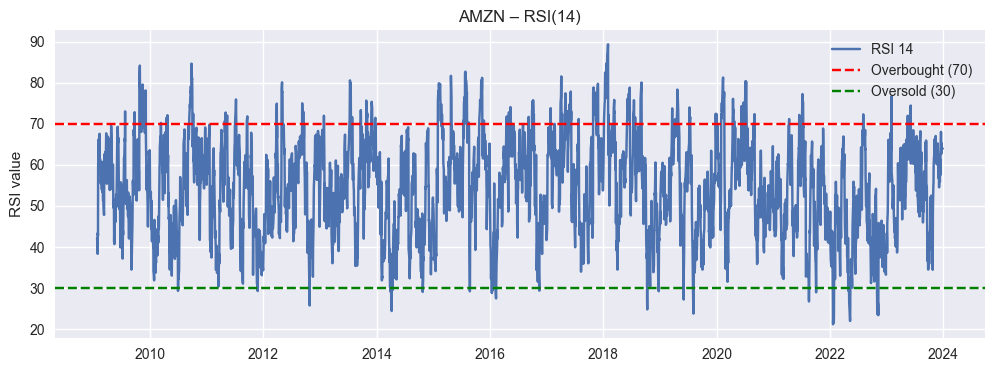

In [20]:
# ============================================
# RSI – Overbought / Oversold
# ============================================

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df.index, df["RSI_14"], label="RSI 14")
ax.axhline(70, color="red", linestyle="--", label="Overbought (70)")
ax.axhline(30, color="green", linestyle="--", label="Oversold (30)")

ax.set_title("AMZN – RSI(14)")
ax.set_ylabel("RSI value")
ax.legend()
plt.show()


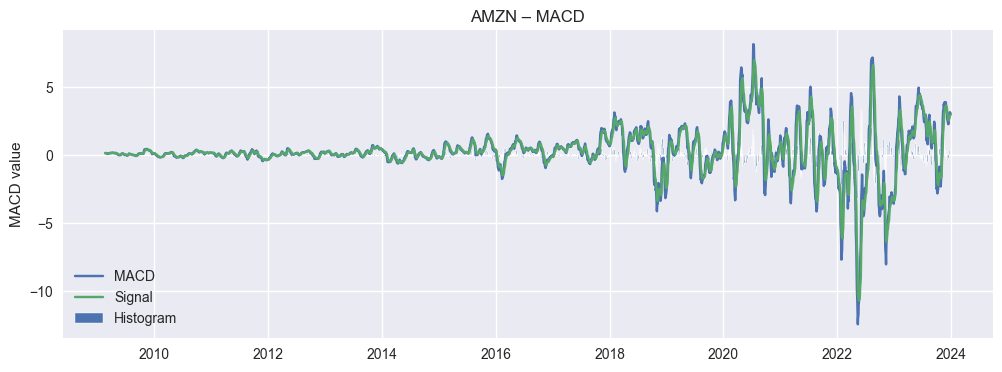

In [21]:
# ============================================
# MACD – Trend & momentum
# ============================================

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df.index, df["MACD"], label="MACD")
ax.plot(df.index, df["MACD_signal"], label="Signal")
ax.bar(df.index, df["MACD_hist"], label="Histogram")

ax.set_title("AMZN – MACD")
ax.set_ylabel("MACD value")
ax.legend()
plt.show()


## Interpretation of Amazon (AMZN) Price & Moving Averages (2009–2024)
1. The Core Price Trend (2009–2021)
- The Close Price (black line) shows an extremely high-growth phase, rising from single digits to its peak near $180 in 2021. The Moving Averages (SMA 20 and SMA 50) confirm this was a dominant bull market:

- The SMA 20 (dashed blue) was almost always above the SMA 50 (dotted green), and both were trending upward, signifying short-term momentum was consistently stronger than medium-term momentum.

- The moving averages served as excellent dynamic support. During minor pullbacks throughout this decade, the price consistently bounced off the SMA 20 or SMA 50 and resumed its climb.

2. The Defining Event: The 2021–2022 Bear Market 
- This period represents the most significant difference between the AMZN chart and the AAPL chart, showcasing the high volatility of Amazon's growth:

- Bearish Crossovers: The sustained uptrend was definitively broken in 2022. The price crashed below both the SMA 20 and SMA 50. Crucially, the SMA 20 crossed decisively below the SMA 50 (a technical "Death Cross" signal, using these short-to-medium averages). This crossover was a strong indication that the positive momentum had completely reversed, initiating a deeper, more prolonged downtrend.

- Averages as Resistance: During this decline, the moving averages reversed roles, acting as dynamic resistance. When the price attempted to rally (bouncing up), it often hit the underside of the SMA 20 or SMA 50 and was immediately sold down again, driving the price lower to its eventual bottom around $80.

3. The 2023 Recovery
- The powerful recovery in 2023 saw the price cut back up through the moving averages. The SMA 20 crossed back above the SMA 50 (a technical "Golden Cross" signal), confirming that the medium-term trend had shifted back to bullish.

- By early 2024, the price was comfortably trading above both averages, which were once again pointing upward, confirming a renewed, strong uptrend.

- In summary, the Moving Averages perfectly charted the AMZN story: they confirmed the long-term bull trend, precisely signaled the start and end of the severe 2022 bear market correction through their crossovers, and are now confirming the stock's return to a bullish path.

## Interpretation of Amazon (AMZN) Relative Strength Index (RSI 14)
- The RSI for AMZN is highly volatile but, unlike AAPL, it confirms that Amazon experienced periods of extreme, sustained fear during its major correction.

1. High Volatility in the Neutral Zone
- The RSI line (blue) oscillates very rapidly across the Neutral Zone (30 to 70), confirming that AMZN has always been a more volatile stock than AAPL, with momentum frequently switching between strong buying and strong selling pressure.

2. Overbought Signals (RSI > 70) 📈
- Similar to other high-growth stocks, the RSI frequently crosses the 70 (Overbought) line throughout the long rally phase (2009–2021). These periods signal intense buying enthusiasm, particularly during the peak of the COVID-era rally.

- Significance: In a dominant uptrend, these high readings confirm the speed of the ascent rather than predicting an immediate top.

3. Critical: Deep, Sustained Oversold Periods (RSI < 30) 📉
- This is the most important feature distinguishing AMZN's momentum from AAPL's. The RSI repeatedly breaks below the 30 (Oversold) line in the later years, most notably in 2022.

Significance:

- 2022 Bear Market Confirmation: The RSI plunging below 30 and remaining low for a sustained period confirms the severe nature of the 2022 correction seen in the price chart. This signals that the selling pressure was intense and prolonged, fueled by significant investor fear and technical breakdown.

- High-Conviction Buy Signals: Every time the RSI has dipped deeply toward or below the 30 line, it has historically coincided with the stock being at or near its eventual bottom (e.g., late 2022). This suggests that the stock was technically oversold, creating a compelling opportunity for long-term buyers.

## Interpretation of Amazon (AMZN) MACD
The MACD (12, 26, 9) measures the relationship between two Exponential Moving Averages (EMAs) to identify changes in the strength, direction, and momentum of the closing price.

1. The Long-Term Trend via the Zero Line
- Bullish Period (2009–2021): For most of this decade-plus rally, the MACD Line and Signal Line are positioned above the Zero Line. This confirms that the short-term momentum of the closing price was consistently faster than the medium-term momentum, indicating a strong, sustained uptrend.

- The 2022 Downtrend: This is the most crucial segment. The MACD plunged dramatically below the Zero Line and remained deep in negative territory for much of 2022.

- Significance: This deep, sustained dip below zero confirms the severe, prolonged loss of momentum and the technical bear market that Amazon experienced. The short-term price average (12-period EMA) became significantly slower than the longer-term average (26-period EMA). The depth of this dip (reaching values near -12) shows the extreme intensity of the selling pressure.

2. Crossover Signals: Volatility and Entry Points
- The crossovers (where the MACD Line crosses the Signal Line) confirm the high volatility seen in the price and RSI charts:

- Buy Signals (MACD crosses ABOVE Signal Line): These crossovers signaled new phases of powerful bullish momentum during the long rally. For example, the crossover in early 2023 marked the beginning of the strong recovery phase.

- Sell Signals (MACD crosses BELOW Signal Line): These signals often coincided with the start of major pullbacks or the beginning of the 2022 downtrend, giving investors a clear warning of decelerating momentum.

3. The 2023 Recovery
- As the price recovered, the MACD Line sharply crossed back above the Zero Line and stabilized in positive territory. This confirms that positive momentum was decisively restored, signaling a return to the long-term uptrend (as of early 2024).